# Predict time from minibatch size
## Using logs from Chainer CIFAR100 sample with various BS on mouse
### Goal: predict one epoch time from batch size using Random Forest model

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess, os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
#!ls logs/microseries/DL

In [3]:
logs_directory =  "logs/microseries/mouse"
filename_pattern=re.compile(r"cifar_.*\.log")

list_command = "ls -1 "+logs_directory
files=[]
proc = subprocess.Popen(list_command.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    line = line.strip(" \n")
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logs_directory,line)))

In [4]:
batch_learn_pattern = re.compile(r"^b\s*(\d+)\s+l\s*([0-9\.]+)")
output_pattern = re.compile(r"^(\d+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)")
remove_str="[J"


# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global batch_learn_pattern
    global output_pattern
    global remove_str
    logfile = logfile.strip(" \n")
    with open(logfile,"r") as f:
        lines = f.readlines()
        batch = 0
        time = 0
        epoch = 0
        ind = 0 # DataFrame row numebr (index)
        df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])
        for line in lines:
            s = line.strip(' \n')
            s = s.replace(remove_str,"")
            m = batch_learn_pattern.match(s)
            if m:
                batch = int(m.group(1))
                learn = float(m.group(2))
            else:
                m2 = output_pattern.match(s)
                if m2:
                    epoch = int(m2.group(1))
                    time = float(m2.group(6))
                    if debug: print batch,learn,epoch,time
                    df.loc[ind] = [batch,learn,epoch,time]
                    ind += 1
                    
    return df

In [5]:
df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])
for file in files:
    df1 = fileToDF(file)
    #print df1.head()
    if len(df1) > 0:
        df = pd.concat([df,df1],ignore_index=True)
print df.shape
df.head()

(800, 4)


,batch,learn,epoch,time
0,101.0,0.15,1.0,90.3823
1,101.0,0.15,1.0,90.4984
2,102.0,0.15,1.0,90.1218
3,103.0,0.15,1.0,90.1364
4,104.0,0.15,1.0,90.1099


In [6]:
df.drop(["learn","epoch"],axis=1,inplace=True)

In [7]:
df.head()

,batch,time
0,101.0,90.3823
1,101.0,90.4984
2,102.0,90.1218
3,103.0,90.1364
4,104.0,90.1099


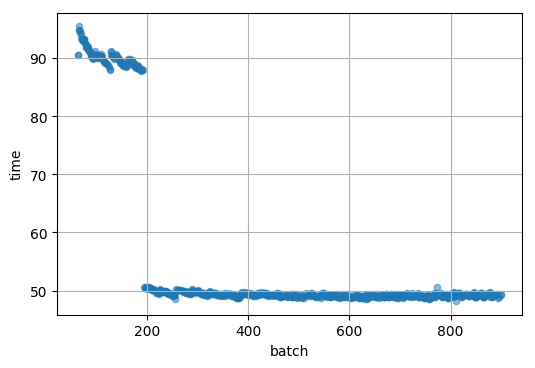

In [8]:
df.plot(kind="scatter",x="batch",y="time",grid=True,alpha=0.5)

In [9]:
# Create training and test sets.
# Use 200 samples for test.
X = df["batch"].values.reshape(-1,1)
Y = df["time"].values

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, shuffle = True)

# X_train = df["batch"][:-200].values
# X_train = X_train.reshape(-1,1)
# print X_train.shape
# Y_train = df["time"][:-200].values
# X_test = df["batch"][-200:].values
# X_test = X_test.reshape(-1,1)
# Y_test = df["time"][-200:].values

#X_test

In [10]:
# Fit Random Forest
clf = RandomForestRegressor(n_estimators=50)
clf = clf.fit(X_train,Y_train)

In [11]:
H_test = clf.predict(X_test)

In [12]:
mean_squared_error(Y_test, H_test)

0.050121953193583611

In [13]:
H_train = clf.predict(X_train)
mean_squared_error(Y_train, H_train)

0.042057110524877407

In [14]:
def plot2sets(X,Y,H):
    fig,ax = plt.subplots()
    ax.scatter(X,Y,alpha=0.5)
    ax.scatter(X, H, color="#ff3300", alpha=0.5)
    ax.grid(linestyle=":",color="black",alpha=.1,linewidth=1)
    return ax

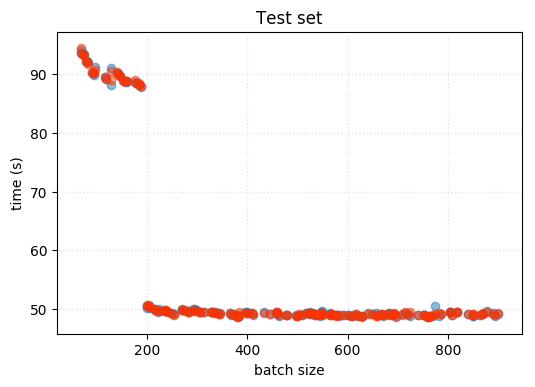

In [15]:
ax = plot2sets(X_test,Y_test,H_test)
ax.set_xlabel("batch size")
ax.set_ylabel("time (s)")
ax.set_title("Test set")
plt.show()

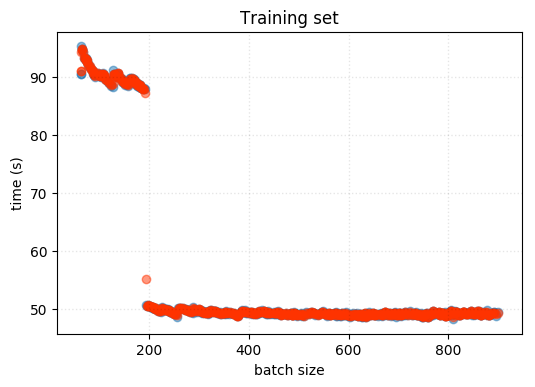

In [16]:
ax = plot2sets(X_train,Y_train,H_train)
ax.set_xlabel("batch size")
ax.set_ylabel("time (s)")
ax.set_title("Training set") 
plt.show()

In [17]:
df[df["batch"] == 400]["time"].values

array([ 49.261])

In [18]:
clf.predict([[400.]])

array([ 49.297782])